# code to produce diurnal cycle of temperature, humidity, lhf and shf
#### author: Claudia Acquistapace 
#### date: 16 Nov 2021
#### 

### Definition of the libraries and the variables

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'

dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}


# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]

def f_clean_lidar_signal_from_noise_v1(data_path, dict_var, noise_mask_file):
    '''
    date: 24/11/2021
    author: Claudia Acquistapace
    input: 
        data_path: string containing the path to the ncdf files of the arthus lidar system
        dict_var : dictionary of settings specific of the variable of interest 
        noise_mask_file: filename including the path of the noise_mask file containing the cloud base height used for the filtering
    output: arthus_data_interp. Xarray dataset containing the variables without the noise
    note: this version of the function (v1) reads the entire dataset at once. For a function working on a single day, check V2
    '''
    arthus_files = np.sort(glob.glob(data_path+'*.cdf'))

    # merging data from each day in a single xarray dataset
    arthus_data = xr.open_mfdataset(arthus_files)


    # removing time duplicates for LHF and SHF file
    if (dict_var['var_name'] == 'LHF') | (dict_var['var_name'] == 'SHF'):
        _, index = np.unique(arthus_data['Time'], return_index=True)
        arthus_data = arthus_data.isel(Time=index)
        print('removed duplicates of time stamps')
        
        
    # set to nan the values out of the thresholds for the selected variable
    mask = (arthus_data["Product"].values > dict_var['thr_min']) & (arthus_data["Product"].values < dict_var['thr_max'])
    arthus_data["nans"] = xr.full_like(arthus_data.Product, fill_value=np.nan)
    arthus_data['Product'] = xr.where(mask, arthus_data['Product'], arthus_data["nans"])
    
    
    # opening noise mask file to read cloud base
    noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
    noise_mask = xr.open_dataset(noise_mask_file)
    cloud_base = noise_mask.cloud_base_height.values


    # interpolating time of the arthus product (T,WVMR, LHF, SHF) on the time of the noise mask (BR ratio time res)
    arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

    # find closest height of arthus data to the threshold height for every time stamp
    arthus_height_thr = []
    for ind_t in range(len(arthus_data_interp.Time.values)):
        arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, cloud_base[ind_t])])    


    # building noise mask for arthus_data
    mask = np.ones((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
    for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
        ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
        mask[ind,ind_zero[0]] = 0.
        

    # applying the mask to the product variable
    arthus_data_interp["nans"] = xr.full_like(arthus_data_interp.Product, fill_value=np.nan)
    arthus_data_interp['Product'] = xr.where(mask, arthus_data_interp['Product'], arthus_data_interp["nans"])
    
    return(arthus_data_interp)


def f_calc_diurnal_cycle(arthus_data_interp, dict_var, path_out):
    '''
    date: 24/11/2021
    author: Claudia Acquistapace
    input: 
        arthus_data_interp: xarray dataset containing the data over which to calculate diurnal cycle
        dict_var : dictionary of settings specific of the variable of interest 
        path_out: output path for the ncdf file containing the diurnal cycle

    goal: calculate the diurnal cycle of the input variable and save it in ncdf. The time resolution for the diurnal
    cycle is stored in dict_var['avg_time'] and depends on the variable to process.
    
    '''
    # calculating the mean of the variable over the time interval requested
    arthus_data_interp = arthus_data_interp.resample(Time=dict_var['avg_time']+'T').mean()

    # re-writing time array as hh:mm for then being able to group
    arthus_data_interp['Time'] = pd.to_datetime(arthus_data_interp.Time.values).strftime("%H:%M")

    # grouping and calculating mean of the profiles
    grouped_mean = arthus_data_interp.groupby('Time').mean()
    grouped_std = arthus_data_interp.groupby('Time').std()
    
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                                 grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                                 vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                            location='right', aspect=20, use_gridspec=grid)
    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
                fontweight='black', transform=axs.transAxes)
    
    # saving diurnal cycle in ncdf file
    dims             = ['Time','Height']
    coords           = {"Time":pd.to_datetime(grouped_mean['Time'].values), "Height":grouped_mean['Height'].values}
    diurnal_cycle       = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['Product'].values,\
                         attrs={'long_name':'diurnal cycle over '+dict_var['avg_time']+'min for '+dict_var['var_string'],\
                                'units':dict_var['var_units']})
    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'AUTHOR_NAME'          : 'Claudia Acquistapace',
                        'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : 'diurnal cycle of the variable '+dict_var['var_string']+'calculated over '+dict_var['avg_time']+'minutes',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
    dataset    = xr.Dataset(data_vars = {'diurnal_cycle':diurnal_cycle},
                                      coords = coords,
                                       attrs = global_attributes)
    dataset.to_netcdf(path_out+dict_var['var_name']+'_diurnal_cycle.nc')


In [2]:
# testing the function 
dict_var = T_dict
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

arthus_no_noise = f_clean_lidar_signal_from_noise_v1(data_path, dict_var, noise_mask_file)

(18289.0, 18289.5)

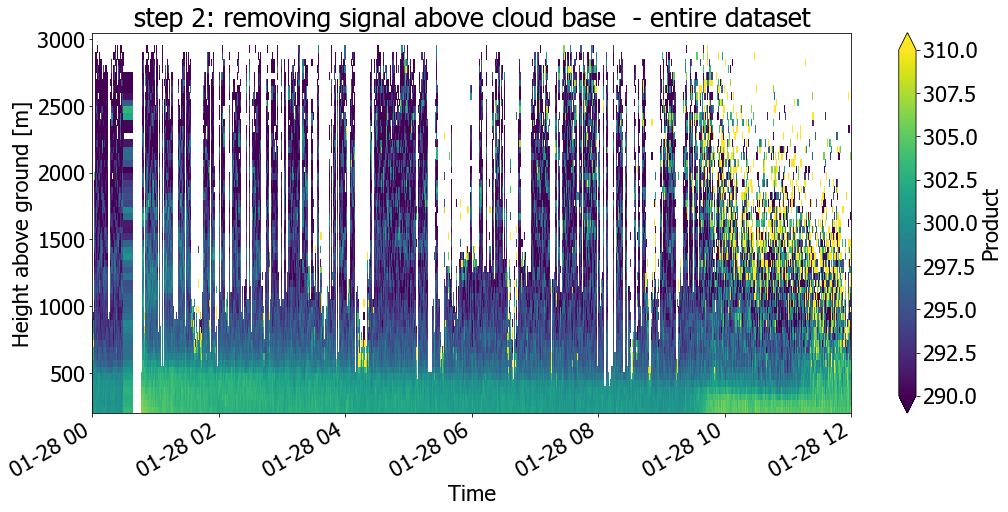

In [3]:
# plotting the result 
fig, ax = plt.subplots(figsize =(17, 7))
arthus_no_noise['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.set_title('step 2: removing signal above cloud base  - entire dataset')
#ax.scatter(pd.to_datetime(noise_mask['Time'].values), cloud_base, marker='v', color='red')

ax.set_xlim(datetime(2020,1,28,0,0,0), datetime(2020,1,28,12,0,0))

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-1-a90be0703fb2>:209: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \


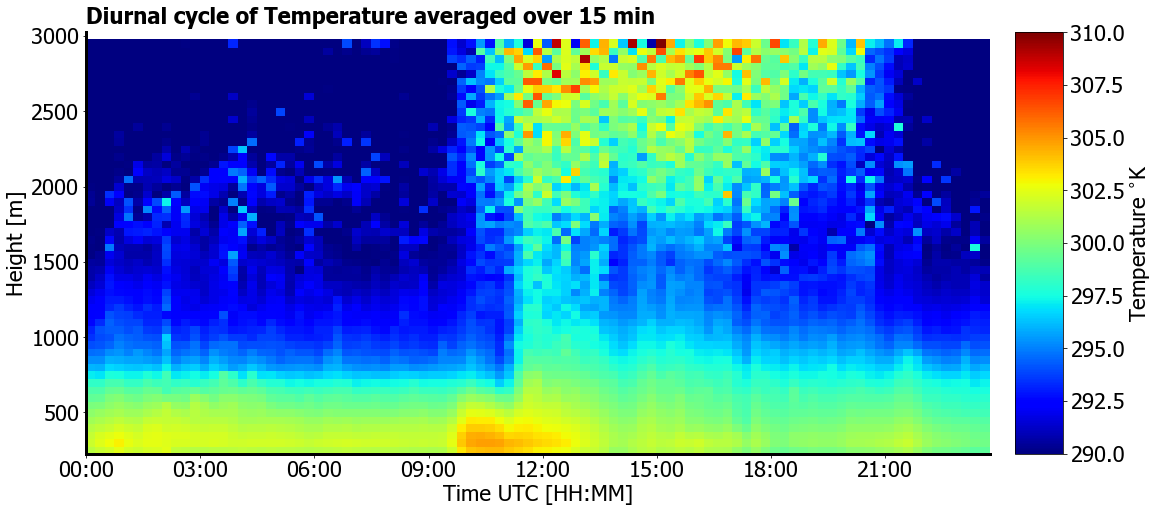

In [4]:
# calculating diurnal cycle using the function above
result = f_calc_diurnal_cycle(arthus_no_noise, dict_var, path_out)

### Test of the filtering methodology on one variable

(18289.0, 18289.5)

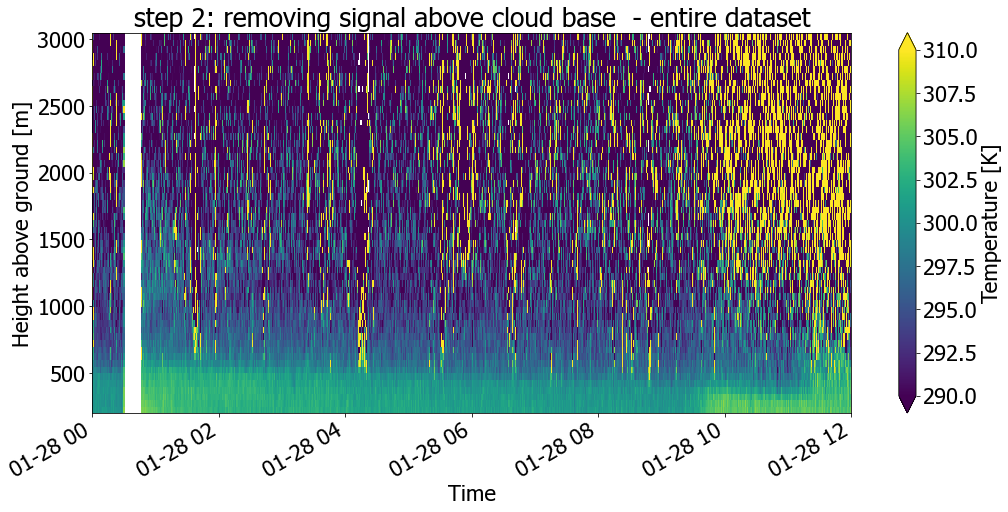

In [8]:
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

arthus_files = np.sort(glob.glob(data_path+'*.cdf'))

# merging data from each day in a single xarray dataset
arthus_data = xr.open_mfdataset(arthus_files)

fig, ax = plt.subplots(figsize =(17, 7))
arthus_data['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.set_title('step 2: removing signal above cloud base  - entire dataset')
#ax.scatter(pd.to_datetime(noise_mask['Time'].values), cloud_base, marker='v', color='red')

ax.set_xlim(datetime(2020,1,28,0,0,0), datetime(2020,1,28,12,0,0))

processing var : SHF
removed duplicates of time stamps


(18289.041666666668, 18289.083333333332)

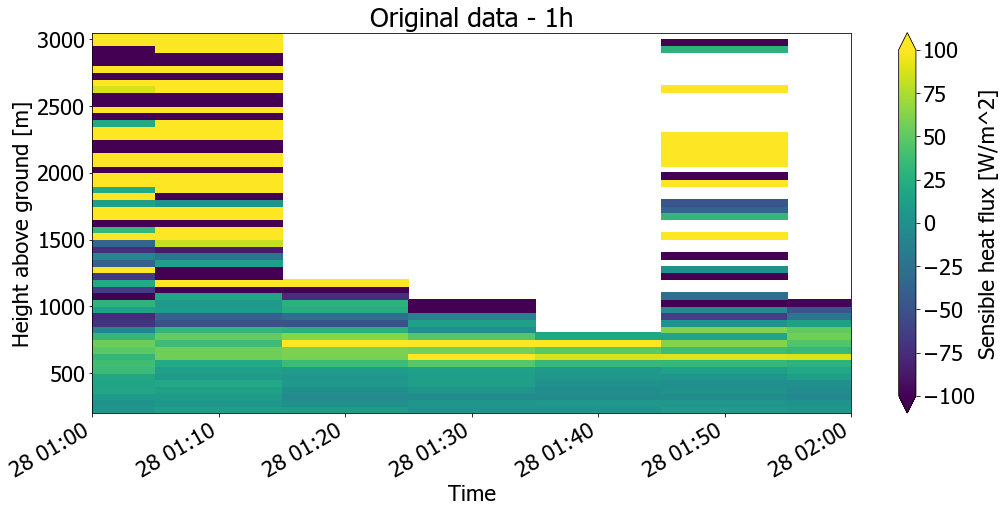

In [3]:
# read dictionary for the variable
dict_var = SHF_dict

# print var processed
print('processing var : '+str(dict_var['var_name']))


# paths
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

arthus_files = np.sort(glob.glob(data_path+'*.cdf'))

# merging data from each day in a single xarray dataset
arthus_data = xr.open_mfdataset(arthus_files)


# removing time duplicates for LHF and SHF file
if (dict_var['var_name'] == 'LHF') | (dict_var['var_name'] == 'SHF'):
    _, index = np.unique(arthus_data['Time'], return_index=True)
    arthus_data = arthus_data.isel(Time=index)
    print('removed duplicates of time stamps')


fig, ax = plt.subplots(figsize =(17, 7))
arthus_data['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.set_title('Original data - 1h')
ax.set_xlim(datetime(2020,1,28,1,0,0), datetime(2020,1,28,2,0,0))

### STEP 1: removing the outliers using thrsholds provided by Diego

(18289.041666666668, 18289.083333333332)

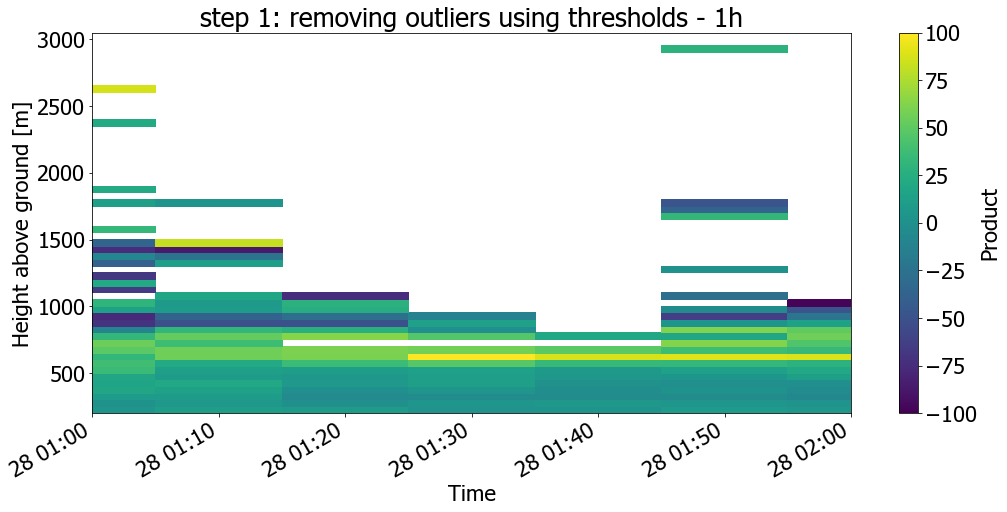

In [4]:
# set to nan the values out of the thresholds for the selected variable
mask = (arthus_data["Product"].values > dict_var['thr_min']) & (arthus_data["Product"].values < dict_var['thr_max'])
arthus_data["nans"] = xr.full_like(arthus_data.Product, fill_value=np.nan)
arthus_data['Product'] = xr.where(mask, arthus_data['Product'], arthus_data["nans"])

fig, ax = plt.subplots(figsize =(17, 7))
arthus_data['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.set_title('step 1: removing outliers using thresholds - 1h')

ax.set_xlim(datetime(2020,1,28,1,0,0), datetime(2020,1,28,2,0,0))

### EVALUATION: compare data over 10 minutes with cloud base height estimated using BR ratio max gradient contained in (noise_mask.nc) file

(18289.065972222223, 18289.072916666668)

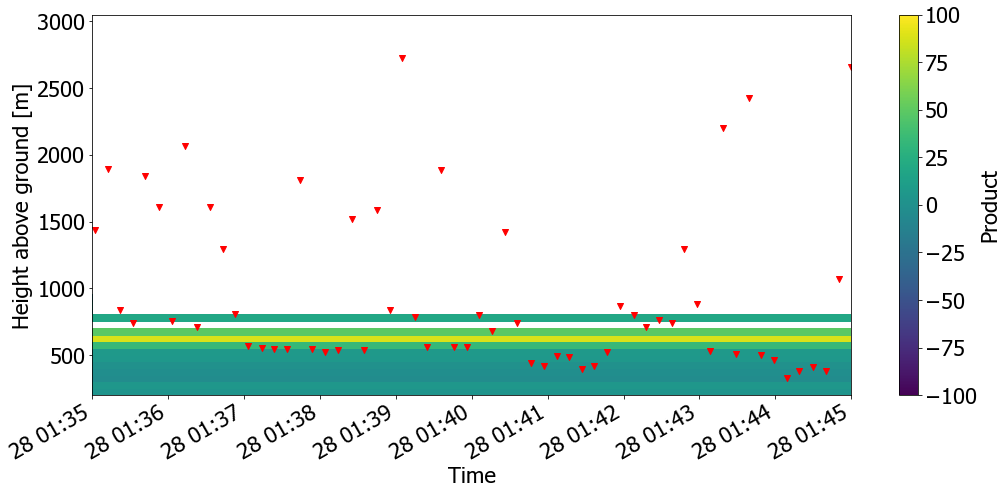

In [5]:
# reading noise mask file and remove noise from the variable
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
cloud_base = noise_mask.cloud_base_height.values


fig, ax = plt.subplots(figsize =(17, 7))
arthus_data['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.scatter(pd.to_datetime(noise_mask['Time'].values), cloud_base, marker='v', color='red')
ax.set_xlim(datetime(2020,1,28,1,35,0), datetime(2020,1,28,1,45,0))

It is possible to notice, at 01:41-01:42, that some signal is not stopped by the cloud base. We want to remove everything measured above the cloud base height.

### STEP 2: removal of all signal measured above cloud base

(18289.583333333332, 18289.927083333332)

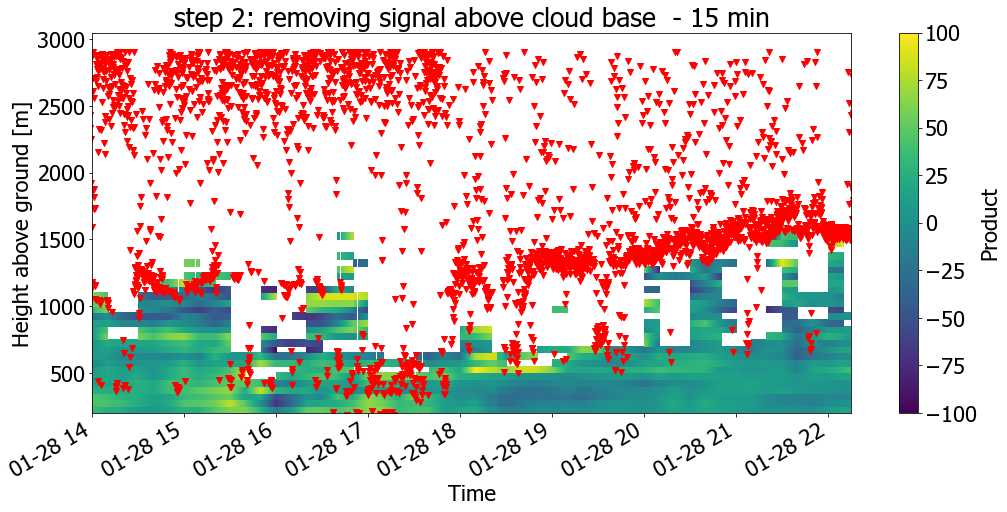

In [6]:
# interpolating time of the arthus product (T,WVMR, LHF, SHF) on the time of the noise mask (BR ratio time res)
arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

# find closest height of arthus data to the threshold height for every time stamp
arthus_height_thr = []
for ind_t in range(len(arthus_data_interp.Time.values)):
    arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, cloud_base[ind_t])])    

    
# building noise mask for arthus_data
mask = np.ones((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
    ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
    mask[ind,ind_zero[0]] = 0.
    
# applying the mask to the product variable
arthus_data_interp["nans"] = xr.full_like(arthus_data_interp.Product, fill_value=np.nan)
arthus_data_interp['Product'] = xr.where(mask, arthus_data_interp['Product'], arthus_data_interp["nans"])

# plotting the result 
fig, ax = plt.subplots(figsize =(17, 7))
arthus_data_interp['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.scatter(pd.to_datetime(noise_mask['Time'].values), cloud_base, marker='v', color='red')
ax.set_title('step 2: removing signal above cloud base  - 15 min')
ax.set_xlim(datetime(2020,1,28,14,0,0), datetime(2020,1,28,22,15,0))

### EVALUATION: plotting the result for three days in a raw

(18289.0, 18292.0)

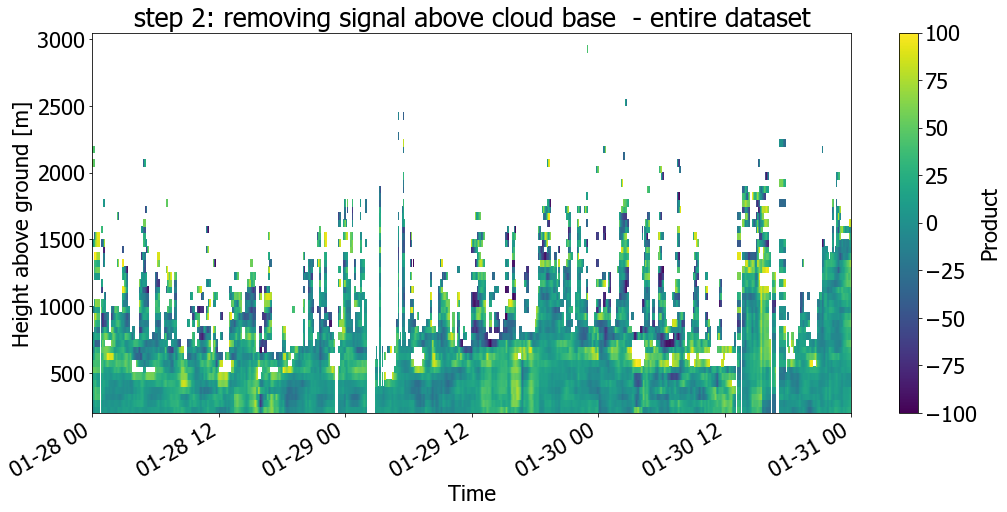

In [7]:
# plotting the result 
fig, ax = plt.subplots(figsize =(17, 7))
arthus_data_interp['Product'].plot(x="Time", y='Height', vmin=dict_var['var_min'], vmax=dict_var['var_max'])
ax.set_title('step 2: removing signal above cloud base  - entire dataset')
#ax.scatter(pd.to_datetime(noise_mask['Time'].values), cloud_base, marker='v', color='red')

ax.set_xlim(datetime(2020,1,28,0,0,0), datetime(2020,1,31,0,0,0))

It can be noticed that between 12 and 18 on each day, there is noise above 1200 m. My impression is that this noise is caused by the sunlight entering in the instrument, that decreases the signal to noise ratio and makes the signal more noisy. 

### STEP 3: calculation of the diurnal cycle over the assigned time interval for the variable

In [4]:
# calculating the mean of the variable over the time interval requested
arthus_data_interp = arthus_data_interp.resample(Time=dict_var['avg_time']+'T').mean()

# re-writing time array as hh:mm for then being able to group
arthus_data_interp['Time'] = pd.to_datetime(arthus_data_interp.Time.values).strftime("%H:%M")

# grouping and calculating mean of the profiles
grouped_mean = arthus_data_interp.groupby('Time').mean()
grouped_std = arthus_data_interp.groupby('Time').std()


NameError: name 'arthus_data_interp' is not defined

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-9-ef9990ca9e3d>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \


Text(0, 1.02, 'Diurnal cycle of Sensible heat flux averaged over 30 min')

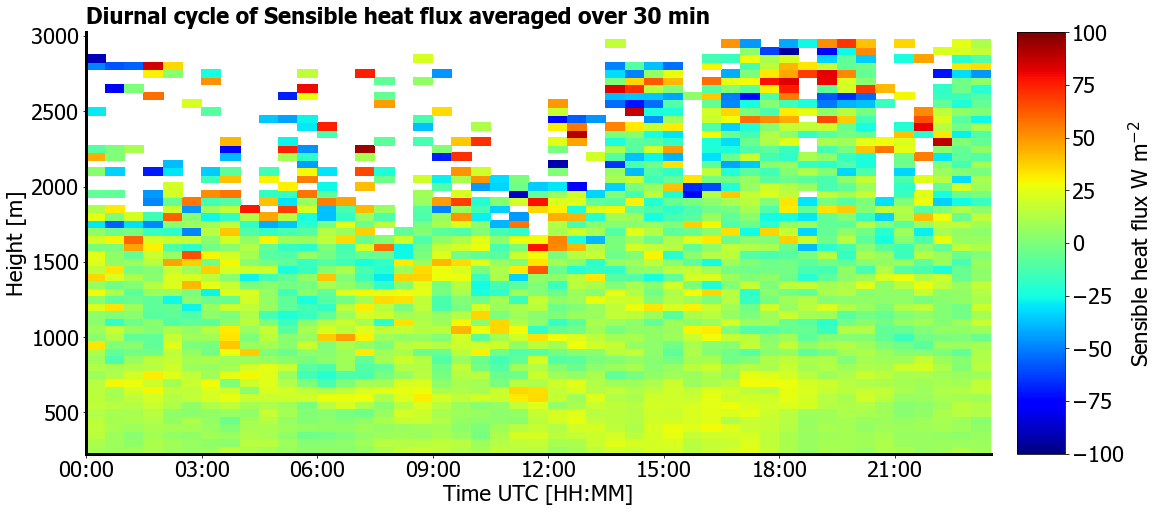

In [9]:
fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                             grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
axs.set_xlabel('Time UTC [HH:MM]')
axs.set_ylabel('Height [m]')
axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
            fontweight='black', transform=axs.transAxes)

### STEP 4: saving diurnal cycle matrix in a ncdf 



In [10]:
dims             = ['Time','Height']
coords           = {"Time":pd.to_datetime(grouped_mean['Time'].values), "Height":grouped_mean['Height'].values}
diurnal_cycle       = xr.DataArray(dims=dims, coords=coords, data=grouped_mean['Product'].values,\
                     attrs={'long_name':'diurnal cycle over '+dict_var['avg_time']+'min for '+dict_var['var_string'],\
                            'units':dict_var['var_units']})
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'AUTHOR_NAME'          : 'Claudia Acquistapace',
                    'AUTHOR_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'AUTHOR_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'AUTHOR_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : 'diurnal cycle of the variable '+dict_var['var_string']+'calculated over '+dict_var['avg_time']+'minutes',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'arthus data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                     'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset    = xr.Dataset(data_vars = {'diurnal_cycle':diurnal_cycle},
                                  coords = coords,
                                   attrs = global_attributes)
dataset.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'_diurnal_cycle.nc')


### FROM HERE BELOW: OLD CODE (NOT USED ANYMORE)

In [1]:
# read dictionary for the variable
dict_var = T_dict

# print var processed
print('processing var : '+str(dict_var['var_name']))


# paths
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

arthus_files = np.sort(glob.glob(data_path+'*.cdf'))

# merging data from each day in a single xarray dataset
arthus_data = xr.open_mfdataset(arthus_files)



# reading noise mask file and remove noise from the variable
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
noise_mask = xr.open_dataset(noise_mask_file)
height_thr = noise_mask.cloud_base_height.values

# interpolating time of the arthus product on the time of the noise mask
arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

# find closest height of arthus data to the threshold height for every time stamp
arthus_height_thr = []
for ind_t in range(len(arthus_data_interp.Time.values)):
    arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, height_thr[ind_t])])    

# building noise mask for arthus_data
mask = np.zeros((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
    ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
    mask[ind,ind_zero[0]] = 1.

# creating a dataset for the variable mask 
dims             = ['Time','Height']
coords           = {"Time":pd.to_datetime(arthus_data_interp['Time'].values), "Height":arthus_data_interp['Height'].values}
mask_noise       = xr.DataArray(dims=dims, coords=coords, data=mask,\
                     attrs={'long_name':'noise mask for arthus data',\
                            'units':''})
noise_mask_new    = xr.Dataset(data_vars = {'noise_mask':mask_noise},
                              coords = coords)

# merging dataset of arthus data and of noise mask
merged_data = xr.merge([arthus_data_interp, noise_mask_new])

# filtering the arthus product variable using the where function and the mask
data_clean = merged_data.Product.where(merged_data.noise_mask.values == 0., np.nan)


# calculating outliers
# calculation of rolling mean over 1 h 
running_mean = data_clean.rolling(min_periods=1, Time=360).mean()  
running_std = data_clean.rolling(min_periods=1, Time=360).std() 

# plot of merged data time serie before removal of the noise
fig, axs = plt.subplots(3, 1, figsize=(16,7), constrained_layout=True)
axs[0].get_yaxis().tick_left()
axs[0].get_xaxis().tick_bottom() 
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(3)
axs[0].spines["left"].set_linewidth(3)

mesh = axs[0].pcolormesh(pd.to_datetime(data_clean['Time'].values), data_clean['Height'].values, \
                         data_clean.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

cbar = fig.colorbar(mesh, ax=axs[0], label=dict_var['var_string']+dict_var['var_units'], \
                    location='right', aspect=20, use_gridspec=grid)
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
axs[0].set_ylim(250., 2000.)
axs[0].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
axs[0].set_xlabel('Time UTC [dd/mm hh]')
axs[0].set_ylabel('Height [m]')


axs[1].get_yaxis().tick_left()
axs[1].get_xaxis().tick_bottom() 
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(3)
axs[1].spines["left"].set_linewidth(3)

mesh = axs[1].pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \
                     running_mean.values.T, vmin=dict_var['var_min'], \
                     vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


cbar = fig.colorbar(mesh, ax=axs[1], label=dict_var['var_string']+dict_var['var_units'], \
                    location='right', aspect=20, use_gridspec=grid)
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
axs[1].set_ylim(250., 2000.)
axs[1].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
axs[1].set_xlabel('Time UTC [dd/mm hh]')
axs[1].set_ylabel('Height [m]')



axs[2].get_yaxis().tick_left()
axs[2].get_xaxis().tick_bottom() 
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["bottom"].set_linewidth(3)
axs[2].spines["left"].set_linewidth(3)

mesh = axs[2].pcolormesh(pd.to_datetime(running_std['Time'].values), running_std['Height'].values, \
                     running_std.values.T, vmin=dict_var['var_min'], \
                     vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


cbar = fig.colorbar(mesh, ax=axs[2], label=dict_var['var_string']+dict_var['var_units'], \
                    location='right', aspect=20, use_gridspec=grid)
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
axs[2].set_ylim(250., 2000.)
axs[2].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
axs[2].set_xlabel('Time UTC [dd/mm hh]')
axs[2].set_ylabel('Height [m]')


fig.savefig(path_out+'{var_name}_time_serie_no_noise.png'.format(**dict_var))


NameError: name 'T_dict' is not defined

processing var : T


<ipython-input-6-3b2b6af89a58>:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(pd.to_datetime(data_clean['Time'].values), data_clean['Height'].values, \
/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-6-3b2b6af89a58>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[1].pcolormesh(pd

NameError: name 'strasukamelo' is not defined

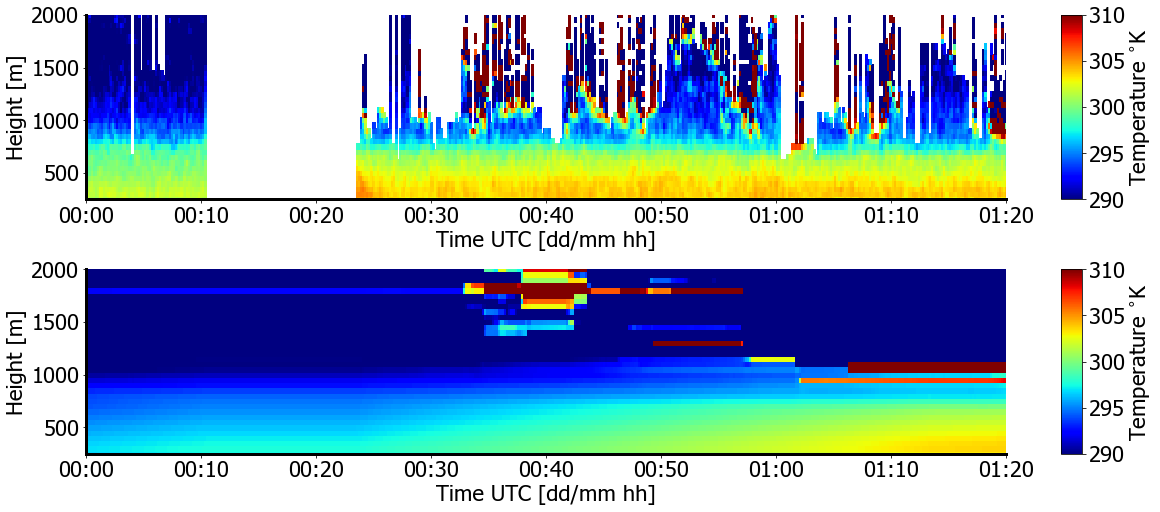

In [6]:

for ind_var,var_name in enumerate(var_list[0]):
    
    # read dictionary for the variable
    dict_var = dict_list[ind_var]
    
    # print var processed
    print('processing var : '+str(dict_var['var_name']))
    
    
    # paths
    data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'

    arthus_files = np.sort(glob.glob(data_path+'*.cdf'))
    
    # merging data from each day in a single xarray dataset
    arthus_data = xr.open_mfdataset(arthus_files)
    
    # reading noise mask file and remove noise from the variable
    noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
    noise_mask = xr.open_dataset(noise_mask_file)
    height_thr = noise_mask.cloud_base_height.values
    
    # interpolating time of the arthus product on the time of the noise mask
    arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

    # find closest height of arthus data to the threshold height for every time stamp
    arthus_height_thr = []
    for ind_t in range(len(arthus_data_interp.Time.values)):
        arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, height_thr[ind_t])])    
    
    # building noise mask for arthus_data
    mask = np.zeros((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
    for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
        ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
        mask[ind,ind_zero[0]] = 1.
    
    # creating a dataset for the variable mask 
    dims             = ['Time','Height']
    coords           = {"Time":pd.to_datetime(arthus_data_interp['Time'].values), "Height":arthus_data_interp['Height'].values}
    mask_noise       = xr.DataArray(dims=dims, coords=coords, data=mask,\
                         attrs={'long_name':'noise mask for arthus data',\
                                'units':''})
    noise_mask_new    = xr.Dataset(data_vars = {'noise_mask':mask_noise},
                                  coords = coords)
    
    # merging dataset of arthus data and of noise mask
    merged_data = xr.merge([arthus_data_interp, noise_mask_new])
    
    # filtering the arthus product variable using the where function and the mask
    data_clean = merged_data.Product.where(merged_data.noise_mask.values == 0., np.nan)
    

    # calculating outliers
    # calculation of rolling mean over 1 h 
    running_mean = data_clean.rolling(min_periods=1, Time=360).mean()  
    running_std = data_clean.rolling(min_periods=1, Time=360).std() 
    
    # plot of merged data time serie before removal of the noise
    fig, axs = plt.subplots(3, 1, figsize=(16,7), constrained_layout=True)
    axs[0].get_yaxis().tick_left()
    axs[0].get_xaxis().tick_bottom() 
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_linewidth(3)
    axs[0].spines["left"].set_linewidth(3)
    
    mesh = axs[0].pcolormesh(pd.to_datetime(data_clean['Time'].values), data_clean['Height'].values, \
                             data_clean.values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig.colorbar(mesh, ax=axs[0], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[0].set_ylim(250., 2000.)
    axs[0].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[0].set_xlabel('Time UTC [dd/mm hh]')
    axs[0].set_ylabel('Height [m]')
    
    
    axs[1].get_yaxis().tick_left()
    axs[1].get_xaxis().tick_bottom() 
    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_linewidth(3)
    axs[1].spines["left"].set_linewidth(3)
    
    mesh = axs[1].pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \
                         running_mean.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


    cbar = fig.colorbar(mesh, ax=axs[1], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[1].set_ylim(250., 2000.)
    axs[1].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[1].set_xlabel('Time UTC [dd/mm hh]')
    axs[1].set_ylabel('Height [m]')
    

    
    axs[2].get_yaxis().tick_left()
    axs[2].get_xaxis().tick_bottom() 
    axs[2].spines["top"].set_visible(False)
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["bottom"].set_linewidth(3)
    axs[2].spines["left"].set_linewidth(3)
    
    mesh = axs[2].pcolormesh(pd.to_datetime(running_std['Time'].values), running_std['Height'].values, \
                         running_std.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)


    cbar = fig.colorbar(mesh, ax=axs[2], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))#('%d/%m %H:%M'))
    axs[2].set_ylim(250., 2000.)
    axs[2].set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))
    axs[2].set_xlabel('Time UTC [dd/mm hh]')
    axs[2].set_ylabel('Height [m]')
    
    
    fig.savefig(path_out+'{var_name}_time_serie_no_noise.png'.format(**dict_var))

    strasukamelo

    

In [11]:
# diurnal cycle calculation: averaging the data on the time resolution of the diurnal cycle and then grouping

    # calculating the mean of the variable over the time interval requested
    arthus_data = arthus_data.resample(Time=dict_var['avg_time']+'T').mean()

    # re-writing time array as hh:mm for then being able to group
    arthus_data['Time'] = pd.to_datetime(arthus_data.Time.values).strftime("%H:%M")

    # grouping and calculating mean of the profiles
    grouped_mean = arthus_data.groupby('Time').mean()
    grouped_std = arthus_data.groupby('Time').std()
    
    # plot figure of the diurnal cycle variable
    fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    axs.spines["bottom"].set_linewidth(3)
    axs.spines["left"].set_linewidth(3)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
    #ax.tick_params(which='minor', length=7, width=3)
    #ax.tick_params(which='major', length=7, width=3)

    mesh1 = axs.pcolormesh(pd.to_datetime(grouped_mean['Time'].values), grouped_mean['Height'].values, \
                             grouped_mean['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

    cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)
    axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs.set_ylim(250., 2000.)

    axs.set_xlabel('Time UTC [HH:MM]')
    axs.set_ylabel('Height [m]')
    axs.text(0, 1.02, 'Diurnal cycle of '+dict_var['var_string']+' averaged over '+dict_var['avg_time']+' min', \
            fontweight='black', transform=axs.transAxes)
    fig2.savefig(path_out+'{var_name}_diurnal_cycle.png'.format(**dict_var))

<xarray.DataArray 'Product' (Time: 61657, Height: 57)>
dask.array<where, shape=(61657, 57), dtype=float32, chunksize=(61657, 57), chunktype=numpy.ndarray>
Coordinates:
  * Height   (Height) float32 225.0 275.0 325.0 375.0 ... 2925.0 2975.0 3025.0
  * Time     (Time) datetime64[ns] 2020-01-28T00:00:05 ... 2020-02-04T23:59:48
Attributes:
    long_name:      Temperature
    standard_name:  Temperature
    units:          K

/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-47-3f0cf7586b8a>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs.pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \


Text(0, 0.5, 'Height [m]')

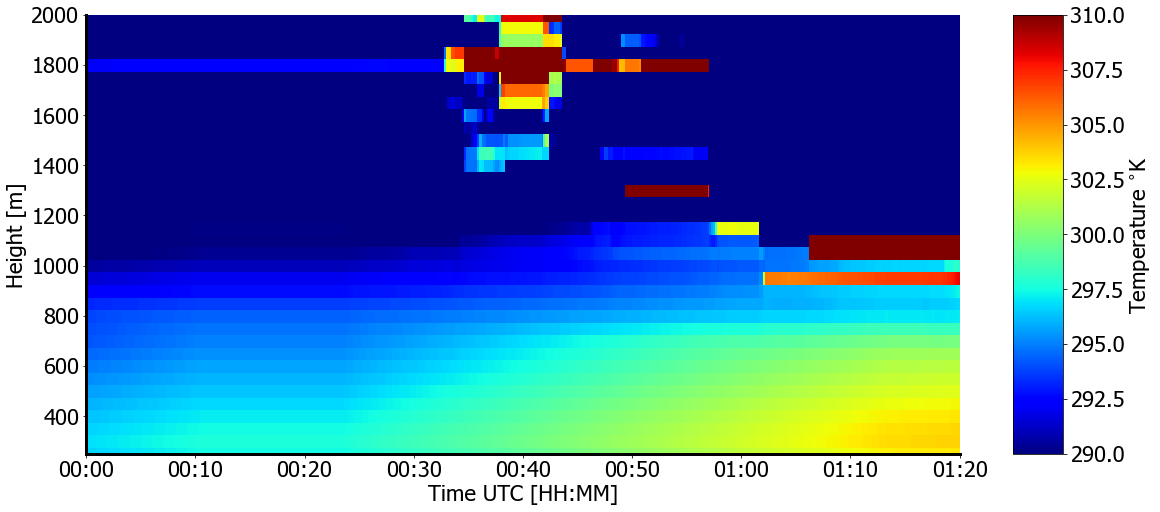

In [47]:
 # plot figure of the diurnal cycle variable
fig2, axs = plt.subplots(1,1, figsize=(16,7), constrained_layout=True)
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
axs.spines["bottom"].set_linewidth(3)
axs.spines["left"].set_linewidth(3)
#ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
#ax.tick_params(which='minor', length=7, width=3)
#ax.tick_params(which='major', length=7, width=3)

mesh1 = axs.pcolormesh(pd.to_datetime(running_mean['Time'].values), running_mean['Height'].values, \
                         running_mean.values.T, vmin=dict_var['var_min'], \
                         vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)

cbar = fig2.colorbar(mesh1, ax=axs, label=dict_var['var_string']+dict_var['var_units'], \
                    location='right', aspect=20, use_gridspec=grid)
axs.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs.set_ylim(250., 2000.)
axs.set_xlim(datetime(2020,2,2,0,0,0), datetime(2020,2,2,1,20,0))

axs.set_xlabel('Time UTC [HH:MM]')
axs.set_ylabel('Height [m]')

#fig2.savefig(path_out+'{var_name}_diurnal_cycle.png'.format(**dict_var))

In [8]:
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/VW/'
arthus_files = np.sort(glob.glob(data_path+'*.cdf'))
    
# merging data from each day in a single xarray dataset
# arthus_data = xr.open_mfdataset(arthus_files)
arthus_data = xr.open_dataset(arthus_files[0])

<ipython-input-4-90f851dc2fc3>:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)


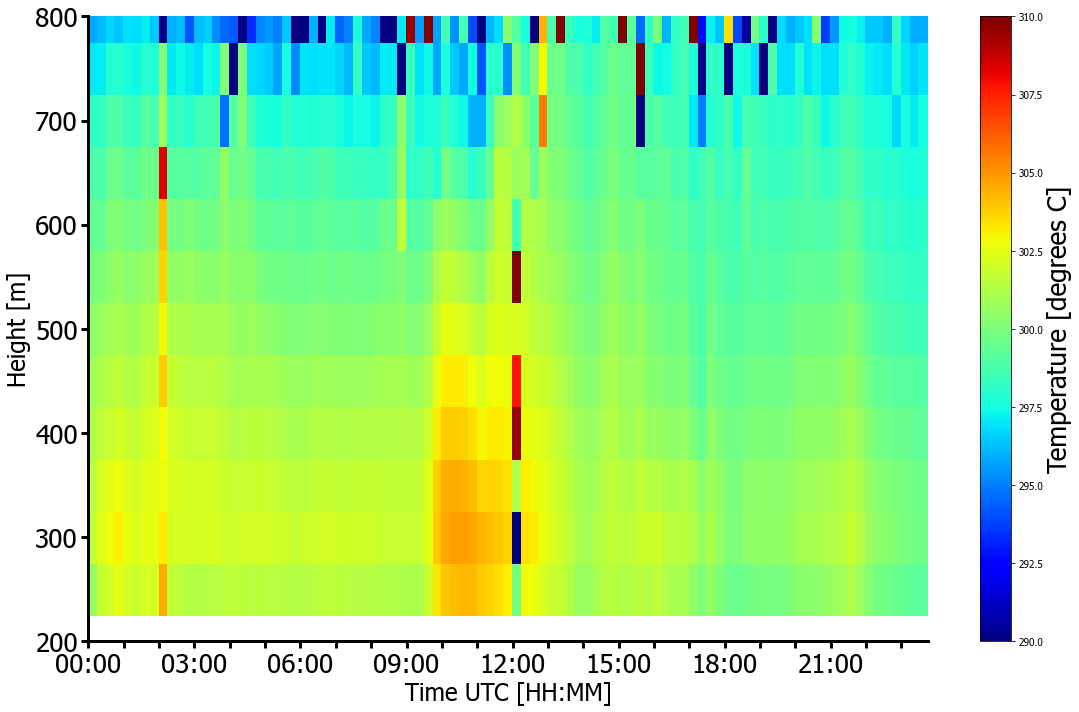

In [4]:
# reading variables for the plot and deriving the plot
T = grouped_mean.Product.values
time = grouped_mean.Time.values
height = grouped_mean.Height.values


labelsizeaxes   = 26
fontSizeTitle   = 26
fontSizeX       = 26
fontSizeY       = 26
cbarAspect      = 26
fontSizeCbar    = 26
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,10))
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.gcf().subplots_adjust(bottom=0.15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=1))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=3))
ax.tick_params(which='minor', length=7, width=3)
ax.tick_params(which='major', length=7, width=3)

#ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.tick_params(axis='both', labelsize=26)

mesh1 = ax.pcolormesh(pd.to_datetime(time), height, T.T, cmap='jet', vmin=290., vmax=310., rasterized=True)
ax.set_xlabel('Time UTC [HH:MM]', fontsize=24)
ax.set_ylabel('Height [m]', fontsize=24)
ax.set_ylim(200., 800.)
cbar = fig.colorbar(mesh1, use_gridspec=True)
cbar.set_label(label='Temperature [degrees C]',  size=26)

fig.tight_layout()
fig.savefig(path_out+'T_diurnal_cycle.png')


-------------------------------------------------------------------------------------------------------------------

(array([ 197.,  238.,  257.,  292.,  325.,  347.,  381.,  427.,  479.,
         549.,  570.,  668.,  746.,  906., 1062., 1198., 1267., 1158.,
         920.,  679.,  529.,  506., 1113., 1132.,  349.,   88.,   61.,
          43.,   29.,   31.,   31.,   22.,   27.,   25.,   20.,   19.,
          12.,    9.,   13.,   30.,   12.,   10.,   10.,   10.,    7.,
           7.,    6.,    3.,    3.]),
 array([280., 281., 282., 283., 284., 285., 286., 287., 288., 289., 290.,
        291., 292., 293., 294., 295., 296., 297., 298., 299., 300., 301.,
        302., 303., 304., 305., 306., 307., 308., 309., 310., 311., 312.,
        313., 314., 315., 316., 317., 318., 319., 320., 321., 322., 323.,
        324., 325., 326., 327., 328., 329.]),
 <BarContainer object of 49 artists>)

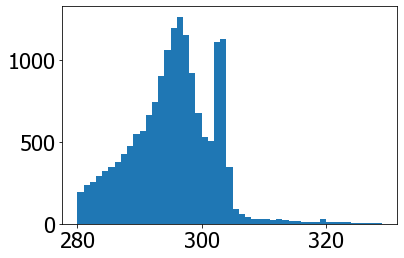

In [112]:
# selecting one hour from the dataset
arthus_hour = arthus_data.sel(Time=slice(datetime(2020,1,28,1,0,0), datetime(2020,1,28,2,0,0)))

# reading hourly matrix of data to nparray
data_hour = arthus_hour['Product'].values

# calcolo della distribuzione 
distr_values = data_hour.flatten()

plt.hist(distr_values, bins=np.arange(280., 330., 1.))

In [25]:
# creating a new object with the same shape and type as the given object and filled with filled_value
#arthus_data["empty"] = xr.full_like(arthus_data.Product.mean("Time"), fill_value=0)

# substituting the values meeting the condition with the second argument, and filling the false values\
# with the corresponding values from the third argument
#arthus_data["empty"] = xr.where((arthus_data.coords["Height"] < 500.), 100, arthus_data["empty"])
arthus_data["Product"] = xr.where((arthus_data["Product"].values < dict_var['thr_min']), \
                                  np.nan, arthus_data["Product"].values)
arthus_data["Product"] = xr.where((arthus_data["Product"].values > dict_var['thr_max']), \
                                  np.nan, arthus_data["Product"].values)

In [110]:
# calcolo della media a tutte le quote: non elimnina gli outliers

# calculating mean and std for every height
arthus_p_mean = np.nanmean(arthus_hour['Product'].values, axis=0)
arthus_p_std = np.nanstd(arthus_hour['Product'].values, axis=0)


# calculating thresholds profiles
profile_thr_sup = arthus_p_mean + 3 * arthus_p_std
profile_thr_inf = arthus_p_mean - 3 * arthus_p_std

for ind_h in range(len(profile_thr_sup)):
    
    # removing values out of the thresholds
    thr_low = profile_thr_inf[ind_h]
    thr_sup = profile_thr_sup[ind_h]
    print(thr_low, thr_sup)
    before = data_hour[:,ind_h]
    # set to nans the values out of the thresholds for the selected variable within the hour
    data_hour[(data_hour[:,ind_h] < thr_low) | (data_hour[:,ind_h] > thr_sup),ind_h] = np.nan
    
# save hourly data filtered in a new dataset
filtered_data = xr.DataArray(dims=['Time', 'Height'], \
                             coords={'Time':arthus_hour['Time'].values, \
                                    'Height':arthus_hour['Height'].values}, \
                             data=data_hour,
                         attrs={'long_name':'data with outliers above 3sigma filtered to nan',
                                'units':''})

301.5796 305.44586
301.38998 305.3154
301.40063 305.24005
301.3992 305.08853
300.98282 304.76865
300.4423 304.51578
299.01285 304.553
296.67117 303.57663
293.19577 305.37943
289.5712 308.0186
282.7427 313.6212
272.09222 322.068
222.75294 370.14532
222.22458 367.0964
190.0318 395.3603
35.63266 563.22266
71.035 522.7632
-100.402374 714.52527
-19686.244 19288.92
-6516.151 7200.614
-100.44028 691.58813
-7502.3257 7749.519
-6312.5093 6607.303
-101.170685 684.724
-2.0231018 582.78125
-82.99008 678.98364
-278.5344 892.61633
-116.83154 703.35645
-123.232635 702.5906
-202.63962 785.5647
-125.78226 725.9551
2.8237305 566.6195
-40.02005 621.79553
-867.70233 1389.2546
-30.52362 612.8963
-5636.899 5939.239
-123.24472 717.579
-90.6911 682.3289
-44.25824 633.2098
-7124.3047 7275.9785
-408.40146 989.9608
-292.62216 895.91296
-85.94641 672.99207
-119.58246 697.435
-45.734314 619.1651
14.663757 544.816
-92.9111 665.3229
-131.3439 708.37537
-122.29309 698.06213
-133.8363 695.8931
-63.737427 624.02014
-12